/Users/satoshan/Library/CloudStorage/Box-Box/scan_org_charts/2010/image00020.jpg


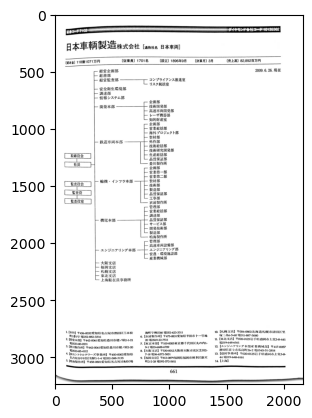

In [2]:
import cv2 as cv2
import os
import matplotlib.pyplot as plt
import easyocr
import pyocr
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import sys
path = "/Users/satoshan/Library/CloudStorage/Box-Box/scan_org_charts/"
path_2010 = path + "2010"

# Choose 2010 of "三井造船"
files = os.listdir(path_2010)
files = [f for f in files if os.path.isfile(os.path.join(path_2010, f))]
files.sort()
file = os.path.join(path_2010, files[19])

# img 
print(file)
img = cv2.imread(file)
plt.imshow(img)
plt.show()

gみコード71 0プイヤモンド会社コード 10135362


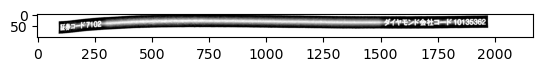

In [3]:
# code detection ocr
header = img[100:200, :]
pil_image = Image.fromarray(header)
tools = pyocr.get_available_tools()
tool = tools[0]
txt = tool.image_to_string(
    pil_image,
    lang="jpn",
    builder=pyocr.builders.TextBuilder(tesseract_layout=11)
)
substring = txt[5:9]
print(txt)

plt.imshow(header)
plt.show()

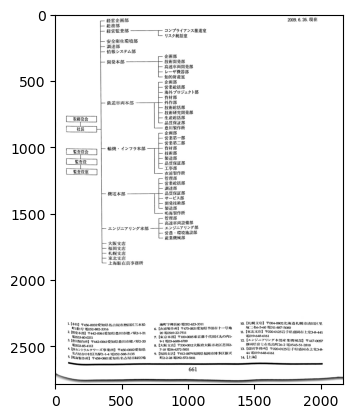

In [4]:
# cutting header
header_size = 450
cropped_image = img[header_size:, :]
plt.imshow(cropped_image)
plt.show()

1894


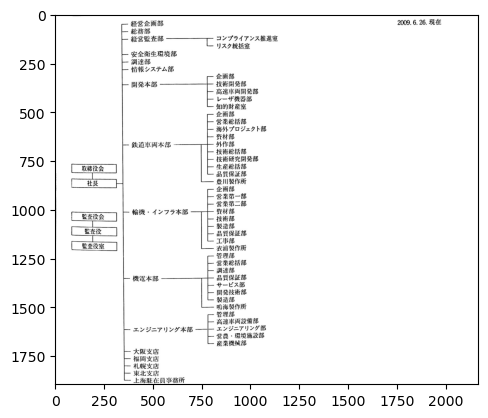

In [5]:
# cutting footer
# make figure biniary
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
gray_image_inv = cv2.bitwise_not(gray_image)

# footer detection
row_sums = np.sum(gray_image_inv, axis=1) 
threshold = 100
empty_row_threshold = 30

empty_row_count = 0
footer_start = None
for i, row_sum in enumerate(row_sums):
    if row_sum < threshold:
        empty_row_count += 1
    else:
        empty_row_count = 0
    if empty_row_count >= empty_row_threshold:
        footer_start = i - empty_row_threshold + 1
        break

if footer_start is not None:
    final_image = cropped_image[:footer_start, :]
else:
    final_image = cropped_image

print(footer_start)
plt.imshow(final_image)
plt.show()

/var/folders/mz/k5cvq67n1cdd51htpfqt0wbh0000gn/T/ipykernel_92722/1580525281.py:22: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


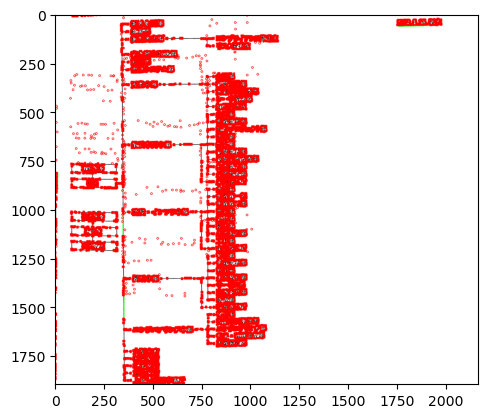

In [17]:
gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)
binary_inv = cv2.bitwise_not(binary)
contours, hierarchy = cv2.findContours(
        binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
contours = list(filter(lambda x: cv2.contourArea(x) > 3000, contours))
# fill 
full = np.zeros_like(img)
cv2.fillPoly(full, pts=contours, color=(255, 255, 255))
full_inv = cv2.bitwise_not(full)
full_gray = cv2.cvtColor(full_inv, cv2.COLOR_BGR2GRAY)

# corner detection
MAX_CORNERS = 500
BLOCK_SIZE = 3
QUALITY_LEVEL = 0.5
MIN_DISTANCE  = 7
corners = cv2.goodFeaturesToTrack(full_gray, MAX_CORNERS, QUALITY_LEVEL,
                                MIN_DISTANCE, blockSize=BLOCK_SIZE,
                                useHarrisDetector=False)
corners = np.int0(corners)

for i in corners:
    x,y=i.ravel()
    cv2.circle(img, (x,y), 5, (0,0,255), 2)

plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.show()